In [401]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Preprocessing the data

#### Cutting the dataset so that there is the same amount of fraud and not fraud cases

We chose to cut it to 5000 fraud and 5000 non-fraud cases for the sake of the model training time


In [402]:
df = pd.read_csv('../data/card_transdata.csv')

df = df.dropna()

fraud_count = df['fraud'].value_counts()
min_count = fraud_count.min()

fraud_df = df[df['fraud'] == 1].sample(n=5000, random_state=42)
non_fraud_df = df[df['fraud'] == 0].sample(n=5000, random_state=42)

df = pd.concat([fraud_df, non_fraud_df])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

#### Separating input and target data and using standar scaling on the continuous values

In [403]:
X = df.drop(columns=["fraud"])
y = df["fraud"]

binary_columns = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]
continuous_columns = [col for col in X.columns if col not in binary_columns]

scaler = StandardScaler()
X_scaled_continuous = scaler.fit_transform(df[continuous_columns])

X_scaled = pd.concat(
    [pd.DataFrame(X_scaled_continuous, columns=continuous_columns), X[binary_columns].reset_index(drop=True)],
    axis=1
)

y = keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(X_scaled.shape)
print(y.shape)

(10000, 7)
(10000, 2)


### Plotting visualizations fo the input data

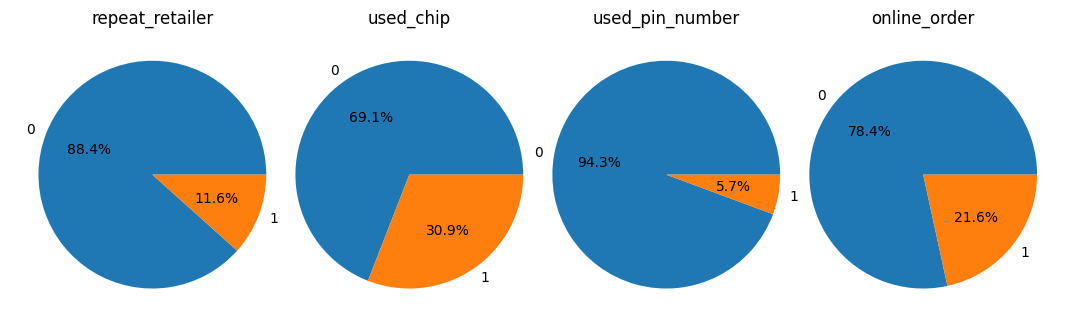

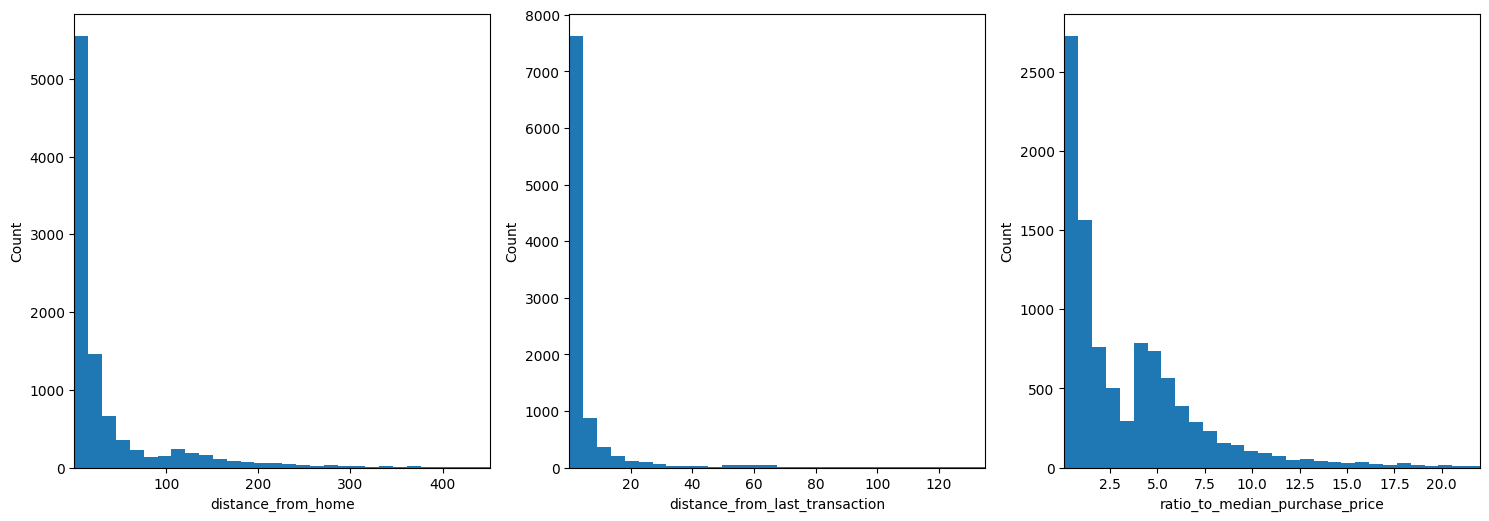

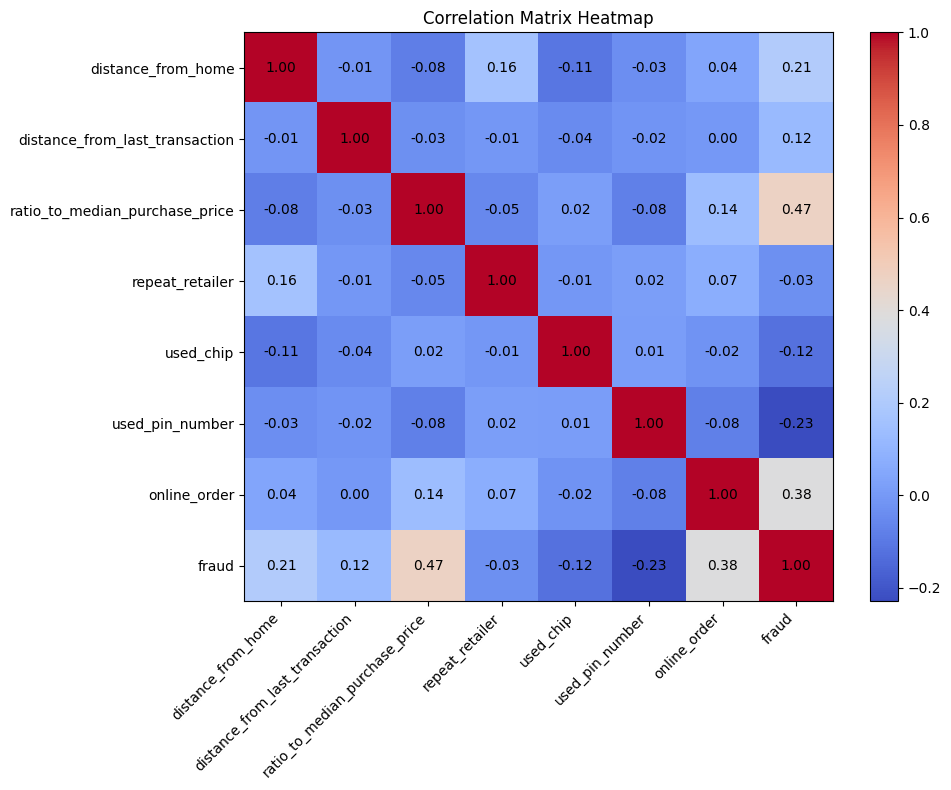

In [404]:
# Plot binary features
plt.figure(figsize=(10, 5))
for i, column in enumerate(binary_columns, 1):
    plt.subplot(1, len(binary_columns), i)
    values = df[column].value_counts()
    plt.pie(values, labels=['0', '1'], autopct='%1.1f%%')
    plt.title(column)
plt.tight_layout(pad=-2)
plt.show()

# Plot continuous features
plt.figure(figsize=(15, 10))
for i, column in enumerate(continuous_columns, 1):
    plt.subplot(2, 3, i)
    q1, q99 = np.percentile(df[column], [1, 99])
    filtered_data = df[column][(df[column] >= q1) & (df[column] <= q99)]
    plt.hist(filtered_data, bins=30)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xlim(q1, q99)
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

### Applying PCA preprocessing to the data

In [405]:
from sklearn.decomposition import PCA

def apply_pca(X_train_scaled, X_test_scaled):
    # Keep 95% of the variance
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # print("Original number of features:", X_train.shape[1])
    # print("Number of features after PCA:", X_train_pca.shape[1])
    # print("Explained variance ratio: {:.2f}".format(sum(pca.explained_variance_ratio_)))

    return X_train_pca, X_test_pca

### Applying t-SNE preprocessing to the data

In [406]:
# Apply t-SNE preprocessing
from sklearn.manifold import TSNE

def apply_tsne(X_train_scaled, X_test_scaled):
    tsne = TSNE(n_components=2, random_state=42)
    X_train_tsne = tsne.fit_transform(X_train_scaled)
    X_test_tsne = tsne.fit_transform(X_test_scaled)

    # print("Original number of features:", X_train.shape[1])
    # print("Number of features after t-SNE:", X_train_tsne.shape[1])

    # plt.figure(figsize=(10, 8))
    # y_train_plot = np.argmax(y_train, axis=1)
    # plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_plot, cmap='viridis')
    # plt.colorbar()
    # plt.title('t-SNE visualization of the training data')
    # plt.xlabel('t-SNE feature 1')
    # plt.ylabel('t-SNE feature 2')
    # plt.show()

    return X_train_tsne, X_test_tsne

### Creating the model

#### Function to create the model

In [407]:
def create_model(
        X_train, # training data
        y_train, # training labels
        X_test, # testing data
        learning_rate=0.001, # learning rate
        validation_split=0.33, # validation split
        epochs=50, # number of epochs
        batch_size=64, # batch size
        patience=3, # patience for early stopping
        loss_function='mean_squared_error', # loss function
        optimizer='adam', # optimizer
        hidden_layer_size=64, # number of neurons in the hidden layer
        num_hidden_layers=1, # number of hidden layers
        early_stopping=True, # early stopping
        use_pca=False, # use PCA
        use_tsne=False, # use t-SNE
        verbose=1 # verbose
):

    # Applying PCA or t-SNE to the data
    if use_pca:
        X_train, X_test = apply_pca(X_train, X_test)
    if use_tsne:
        X_train, X_test = apply_tsne(X_train, X_test)

    #initializing the model and adding the hidden layers
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    # Adding the given number of hidden layers, and decreasing the number of neurons by half each layer
    for i in range(num_hidden_layers):
        model.add(Dense(int(hidden_layer_size/(2**i)), activation='relu')) # Hidden layer
    model.add(Dense(y.shape[1], activation='softmax')) # Output layer

    # Compiling the model with the given optimizer and loss function
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])

    # Adding early stopping with patience of 3
    monitor = EarlyStopping(
        monitor='loss',
        min_delta=1e-3,
        patience=patience,
        verbose=verbose,
        mode='auto', 
        restore_best_weights=True
    )

    # training the model and saving the result to plot later
    result = model.fit(
        X_train,
        y_train,
        validation_split=validation_split,
        verbose=verbose,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[monitor] if early_stopping else [],
    )

    return model, result, X_test

#### Function to plot the results

In [413]:
def print_scores(y_compare, pred):
    # Getting relevant scores values for accuracy, precision, recall, F1 and R2
    score = metrics.accuracy_score(y_compare, pred)
    precision = metrics.precision_score(y_compare, pred)
    recall = metrics.recall_score(y_compare, pred)
    f1 = metrics.f1_score(y_compare, pred)
    r2 = metrics.r2_score(y_compare, pred)
    rmse = np.sqrt(metrics.mean_squared_error(pred,y_compare))

    print("Accuracy score: {:.2f}".format(score))
    print("Precision score: {:.2f}".format(precision))
    print("Recall score: {:.2f}".format(recall))
    print("F1 score: {:.2f}".format(f1))
    print("R2 score: {:.2f}".format(r2))
    print("Mean Square Error: {:.2f}".format(rmse))

    return score, precision, recall, f1, r2, rmse


def plot_graphs(result, y_compare, pred):
    # Loss and accuracy curves for training and validation
    plt.figure(figsize=(10, 8))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

    #confusion matrix
    labels = ['Not Fraud', 'Fraud']

    plt.figure(figsize=(8, 6))
    confusion_mtx = metrics.confusion_matrix(y_compare, pred)
    plt.imshow(confusion_mtx, interpolation='nearest', cmap='Blues')
    plt.colorbar()

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(confusion_mtx.shape[0]):
        for j in range(confusion_mtx.shape[1]):
            plt.text(j, i, str(confusion_mtx[i, j]),
                    ha='center', va='center')

    plt.xticks([0, 1], labels)
    plt.yticks([0, 1], labels)

    plt.tight_layout()
    plt.show()


#### Instantiating the model and testing it with different parameters

In [409]:
results_table = []

epochs = 50
patience = 3
batch_size = 64

for learning_rate in [0.001, 0.01, 0.1]:
    for optimizer in ['adam', 'sgd']:
        for loss_function in ['mean_squared_error', 'binary_crossentropy']:
            for hidden_size in [128, 64, 32]:
                for num_layers in [1, 2, 3]:
                    model, result, X_test_reduced = create_model(
                        X_train,
                        y_train, 
                        X_test,
                        learning_rate=learning_rate,
                        optimizer=optimizer,
                        loss_function=loss_function,
                        batch_size=batch_size,
                        patience=patience,
                        epochs=epochs,
                        hidden_layer_size=hidden_size,
                        num_hidden_layers=num_layers,
                        verbose=0
                    )
                    pred = model.predict(X_test_reduced)
                    pred = np.argmax(pred, axis=1)
                    y_compare = np.argmax(y_test, axis=1)
                    results_table.append({
                        'learning_rate': learning_rate,
                        'optimizer': optimizer,
                        'loss_function': loss_function,
                        'hidden_size': hidden_size,
                        'num_hidden_layers': num_layers,
                        'accuracy': metrics.accuracy_score(y_compare, pred)
                    })

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
94/94 ━━━━━━━━━━━━━━

#### Printing the average accuracy by each parameter

In [410]:
results_df = pd.DataFrame(results_table)

print("Average accuracy by learning rate:")
print(results_df.groupby('learning_rate')['accuracy'].mean())
print("\nAverage accuracy by optimizer:")
print(results_df.groupby('optimizer')['accuracy'].mean())
print("\nAverage accuracy by loss function:")
print(results_df.groupby('loss_function')['accuracy'].mean())
print("\nAverage accuracy by hidden layer size:")
print(results_df.groupby('hidden_size')['accuracy'].mean())
print("\nAverage accuracy by dimensionality reduction method:")
print(results_df.groupby('num_hidden_layers')['accuracy'].mean())

results_df.to_csv('results.csv', index=False)

Average accuracy by learning rate:
learning_rate
0.001    0.944278
0.010    0.969944
0.100    0.944509
Name: accuracy, dtype: float64

Average accuracy by optimizer:
optimizer
adam    0.963309
sgd     0.942512
Name: accuracy, dtype: float64

Average accuracy by loss function:
loss_function
binary_crossentropy    0.961438
mean_squared_error     0.944383
Name: accuracy, dtype: float64

Average accuracy by hidden layer size:
hidden_size
32     0.956185
64     0.948454
128    0.954093
Name: accuracy, dtype: float64

Average accuracy by dimensionality reduction method:
num_hidden_layers
1    0.959935
2    0.966120
3    0.932676
Name: accuracy, dtype: float64


#### Creating the model with the best parameters

In [415]:
model, result, X_test_reduced = create_model(
    X_train,
    y_train, 
    X_test,
    learning_rate=0.001,
    optimizer='adam',
    loss_function='mean_squared_error',
    batch_size=batch_size,
    patience=patience,
    epochs=epochs,
    hidden_layer_size=32,
    num_hidden_layers=2,
    verbose=1
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7143 - loss: 0.2087 - val_accuracy: 0.9273 - val_loss: 0.1115
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9340 - loss: 0.0902 - val_accuracy: 0.9550 - val_loss: 0.0576
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9583 - loss: 0.0500 - val_accuracy: 0.9615 - val_loss: 0.0441
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9622 - loss: 0.0410 - val_accuracy: 0.9632 - val_loss: 0.0386
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9648 - loss: 0.0369 - val_accuracy: 0.9632 - val_loss: 0.0366
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9708 - loss: 0.0312 - val_accuracy: 0.9658 - val_loss: 0.0330
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9684 - loss: 0.0291 - val_accuracy: 0.9671 - val_loss: 0.0313
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9703 - loss: 0.0286 - val_accuracy: 0.9688 - val_loss:

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Accuracy score: 0.99
Precision score: 0.98
Recall score: 0.99
F1 score: 0.99
R2 score: 0.95
Mean Square Error: 0.11


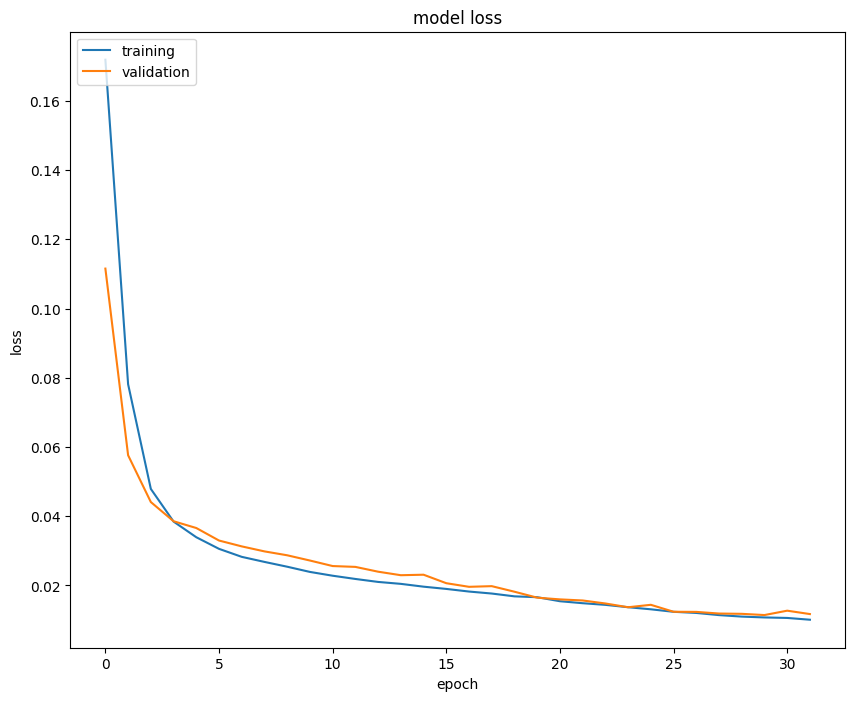

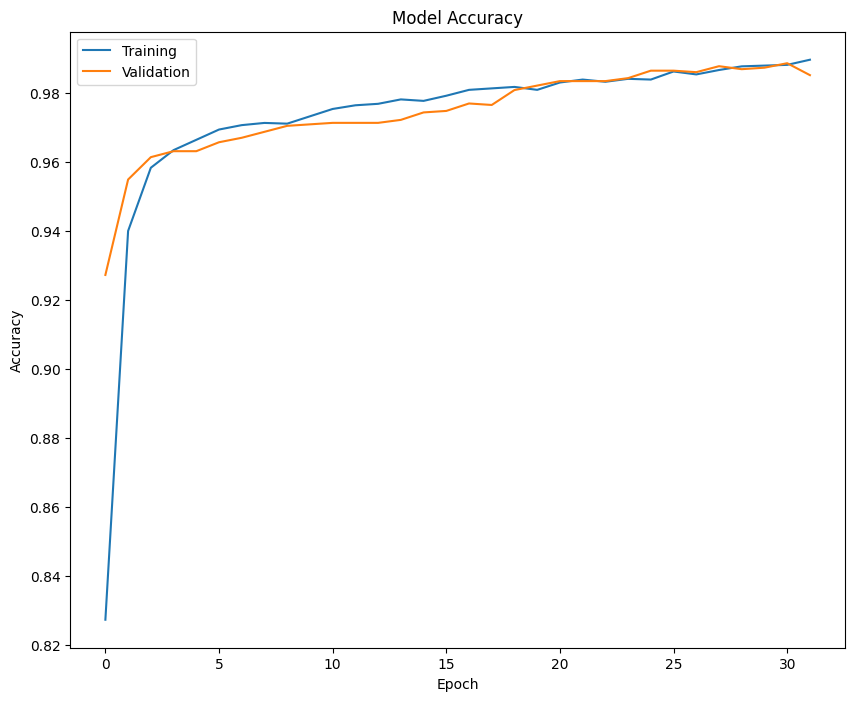

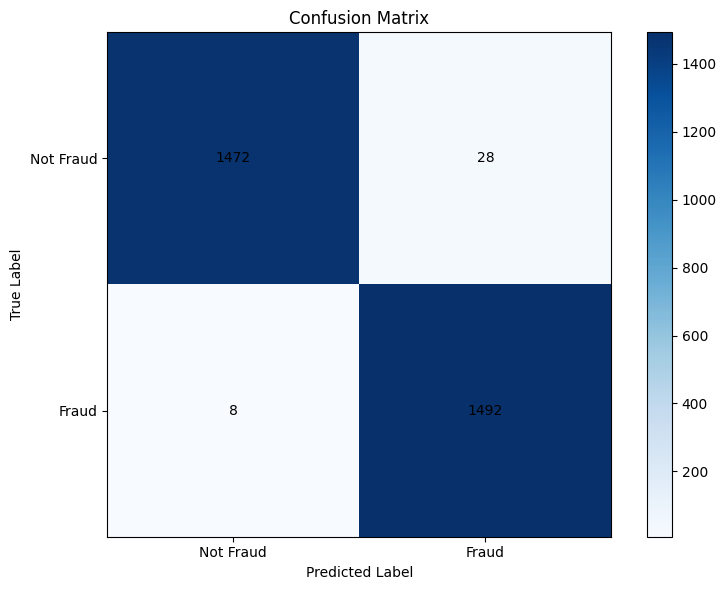

In [416]:
pred = model.predict(X_test_reduced)
pred = np.argmax(pred, axis=1)
y_compare = np.argmax(y_test, axis=1)

print_scores(y_compare, pred)
plot_graphs(result, y_compare, pred)

#### Applying PCA and t-SNE to the data

In [418]:
# PCA
model_pca, result_pca, X_test_pca = create_model(
    X_train,
    y_train,
    X_test,
    learning_rate=0.001,
    optimizer='adam', 
    loss_function='mean_squared_error',
    batch_size=batch_size,
    patience=patience,
    epochs=epochs,
    hidden_layer_size=32,
    num_hidden_layers=2,
    use_pca=True,
    verbose=1
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6438 - loss: 0.2239 - val_accuracy: 0.9334 - val_loss: 0.1175
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9393 - loss: 0.0970 - val_accuracy: 0.9407 - val_loss: 0.0630
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9417 - loss: 0.0578 - val_accuracy: 0.9463 - val_loss: 0.0513
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9520 - loss: 0.0456 - val_accuracy: 0.9481 - val_loss: 0.0472
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9531 - loss: 0.0423 - val_accuracy: 0.9498 - val_loss: 0.0448
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9549 - loss: 0.0405 - val_accuracy: 0.9520 - val_loss: 0.0426
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9591 - loss: 0.0375 - val_accuracy: 0.9524 - val_loss: 0.0410
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9607 - loss: 0.0363 - val_accuracy: 0.9541 - val_loss:

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Results for PCA:
Accuracy score: 0.97
Precision score: 0.95
Recall score: 0.99
F1 score: 0.97
R2 score: 0.89
Mean Square Error: 0.17


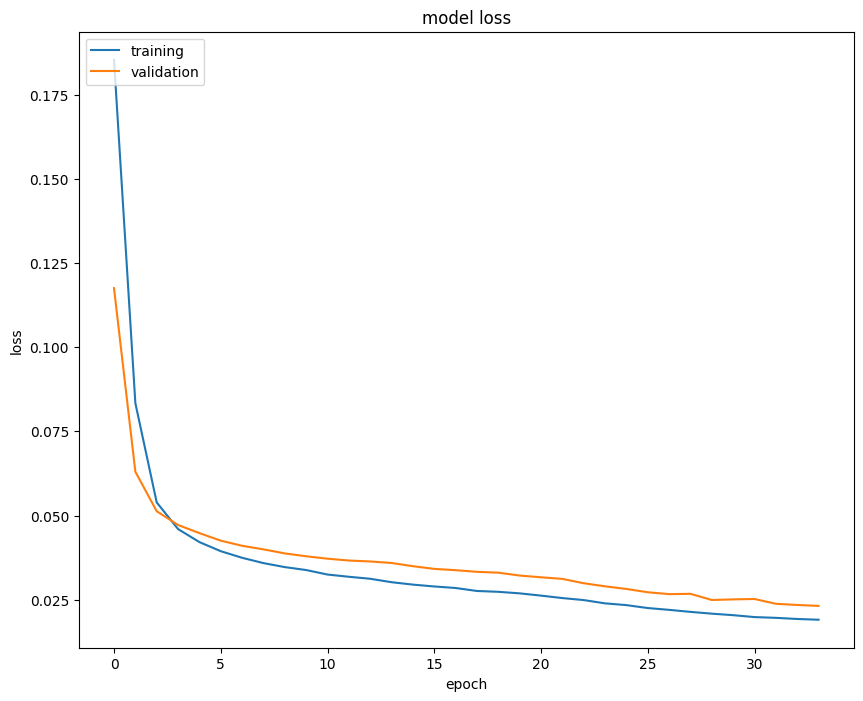

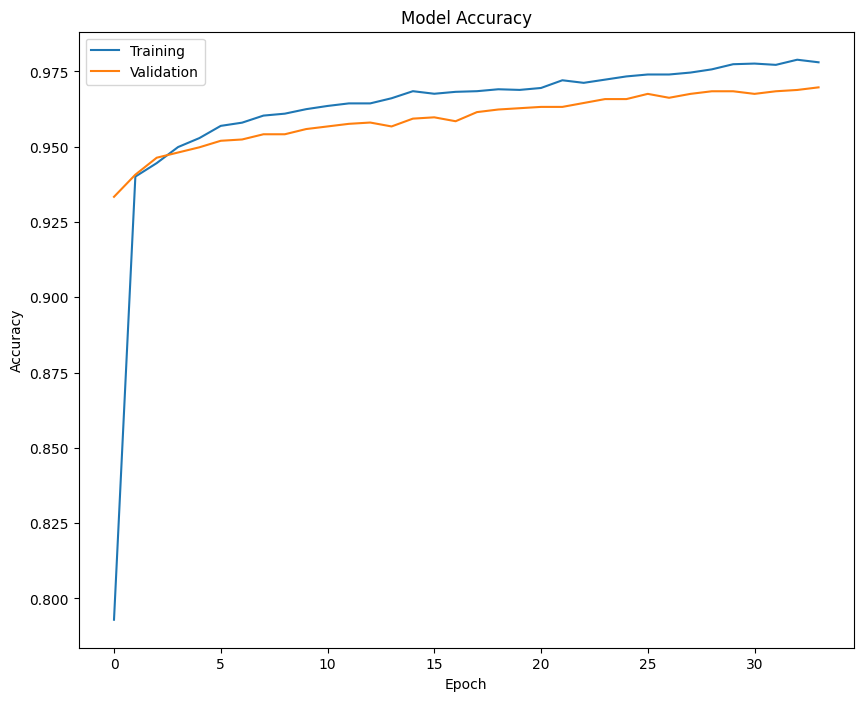

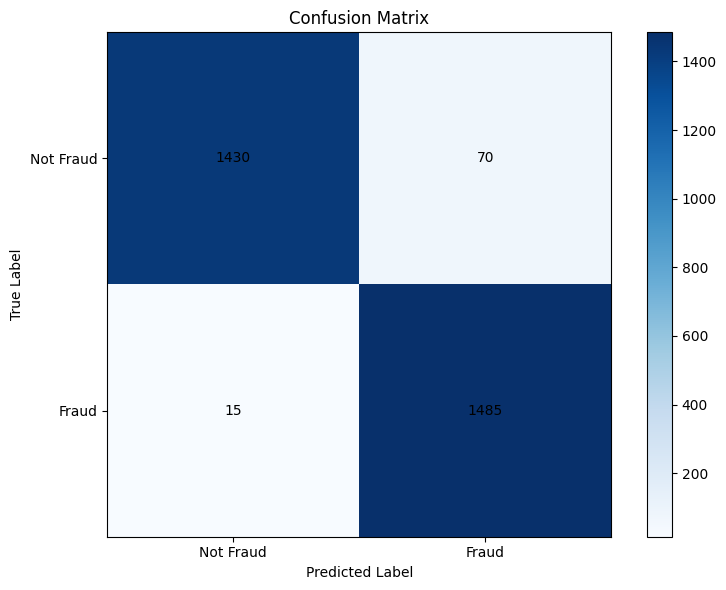

In [419]:
pred_pca = model_pca.predict(X_test_pca)
pred_pca = np.argmax(pred_pca, axis=1)
y_compare = np.argmax(y_test, axis=1)

print("\nResults for PCA:")
print_scores(y_compare, pred_pca)
plot_graphs(result_pca, y_compare, pred_pca)

In [420]:
# t-SNE
model_tsne, result_tsne, X_test_tsne = create_model(
    X_train,
    y_train,
    X_test,
    learning_rate=0.001,
    optimizer='adam',
    loss_function='mean_squared_error',
    batch_size=batch_size,
    patience=patience,
    epochs=epochs,
    hidden_layer_size=32,
    num_hidden_layers=2,
    use_tsne=True,
    verbose=1
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8495 - loss: 0.1243 - val_accuracy: 0.8369 - val_loss: 0.1121
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8562 - loss: 0.1034 - val_accuracy: 0.8550 - val_loss: 0.0906
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8668 - loss: 0.0836 - val_accuracy: 0.8711 - val_loss: 0.0783
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8758 - loss: 0.0818 - val_accuracy: 0.8784 - val_loss: 0.0751
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8808 - loss: 0.0739 - val_accuracy: 0.8832 - val_loss: 0.0698
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8984 - loss: 0.0683 - val_accuracy: 0.9083 - val_loss: 0.0647
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9168 - loss: 0.0652 - val_accuracy: 0.9074 - val_loss: 0.0645
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9258 - loss: 0.0586 - val_accuracy: 0.9316 - val_loss:

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step

Results for t-SNE:
Accuracy score: 0.57
Precision score: 0.57
Recall score: 0.57
F1 score: 0.57
R2 score: -0.74
Mean Square Error: 0.66


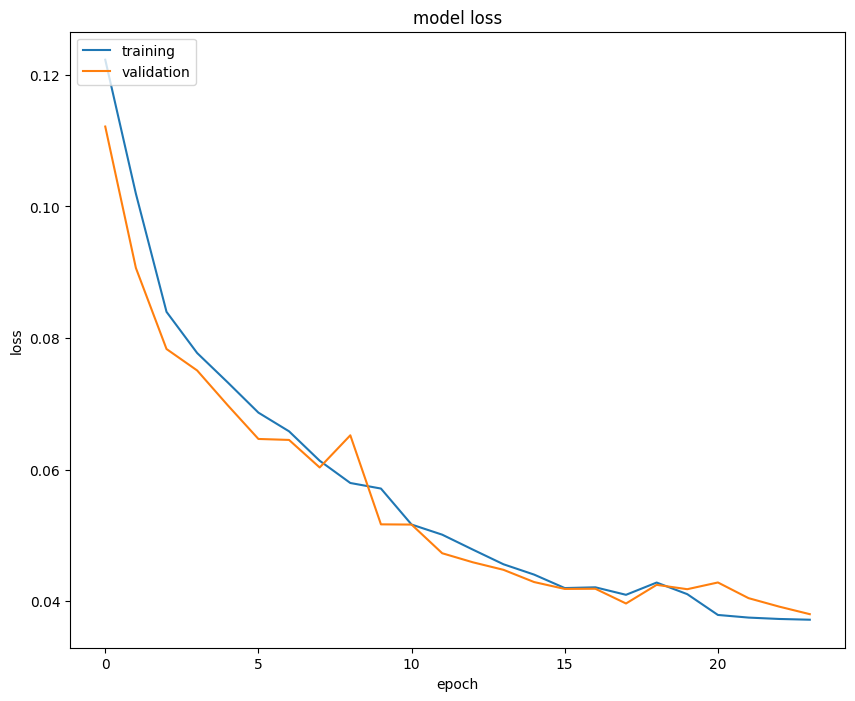

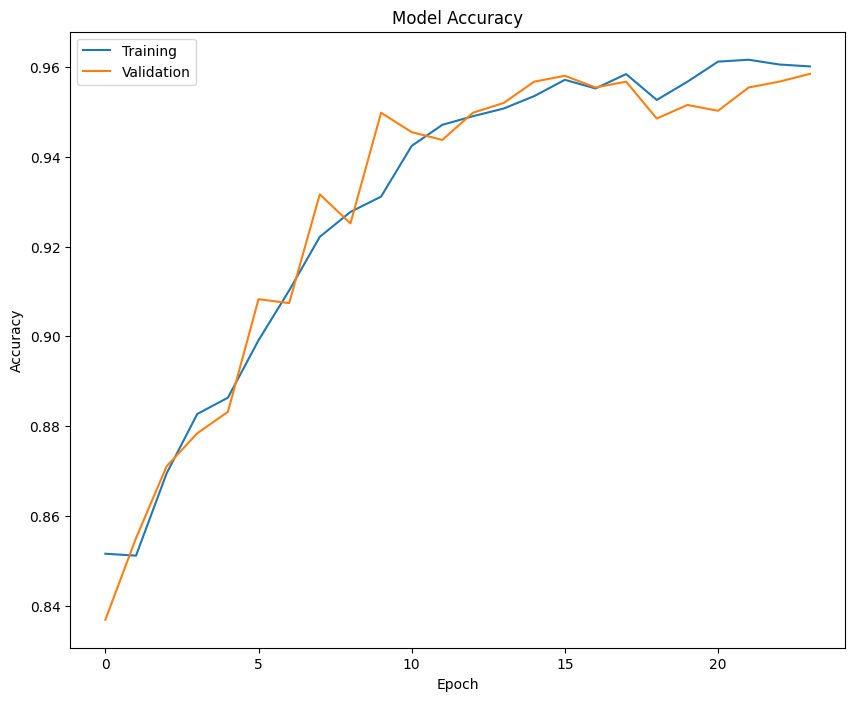

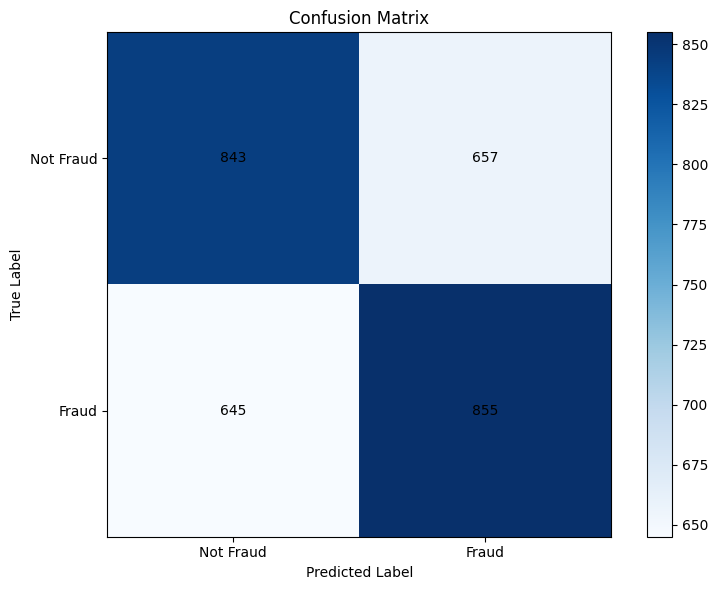

In [423]:
pred_tsne = model_tsne.predict(X_test_tsne)
pred_tsne = np.argmax(pred_tsne, axis=1)

print("\nResults for t-SNE:")
print_scores(y_compare, pred_tsne)
plot_graphs(result_tsne, y_compare, pred_tsne)